In [6]:
from obspy.core.event import read_events
import obspy
import numpy as np
import pandas as pd
from scipy.special import sph_harm
import matplotlib.pyplot as plt
import os.path
import shutil
from obspy import UTCDateTime
from netCDF4 import Dataset
from matplotlib import cm
from skimage.filters import gaussian
from mpl_toolkits.basemap import Basemap
from itertools import chain

from scipy.stats import qmc

dpi = 300
FigFormat = "png"

def draw_map(map):

    # draw a shaded-relief image
    map.shadedrelief(scale=0.2)
    
    # lats and longs are returned as a dictionary
    lats = map.drawparallels(np.linspace(-90, 90, 13))
    lons = map.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')

Text(0.5, 1.0, 'Latin Hypercube Sampling (n = 1000)')

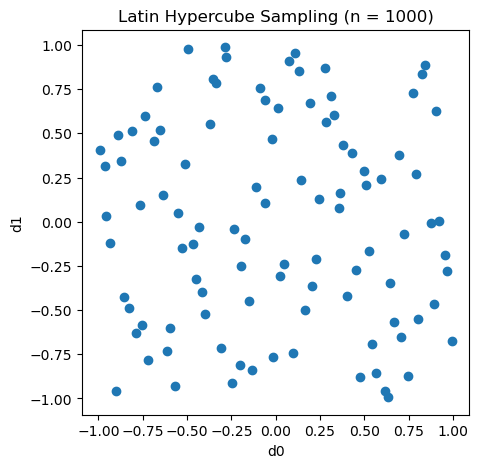

In [7]:
Dim = 81*5*3+7
N = 100
scalerange = 1
sampler = qmc.LatinHypercube(d=Dim)
sample = sampler.random(n=N)
l_bounds = [-scalerange]*Dim
u_bounds = [scalerange]*Dim
sample_scaled = qmc.scale(sample, l_bounds, u_bounds)
np.save('sampling_array_%d_elastic' %N,sample_scaled)

plt.figure(figsize=(5, 5))
plt.scatter(sample_scaled[:, 0], sample_scaled[:, 1])
plt.xlabel("d0")
plt.ylabel("d1")
plt.title(f"Latin Hypercube Sampling (n = {1000})")

In [4]:
sample_scaled = np.load('sampling_array_10000_elastic.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'sampling_array_10000_elastic.npy'

In [6]:
imodel =2
para_index = 2
MomentTensor = sample_scaled[imodel,para_index:para_index+6]

In [7]:
len(MomentTensor)

6

In [9]:
ExampleInputDir = '../Runs/ExampleSphericalHarmonicsElasticBall/input'

SourceDepthRange = [0,300]
DvpRange = 0.025
DvsRange = 0.025
DrhoRange = 0.025

for imodel in np.arange(0,10):

    para_index = 0

    ModeName = 'LatinSphericalHarmonicsElasticBall%04d' %imodel
    EventParDir='../Runs/%s' %(ModeName)  
    if not os.path.exists(EventParDir):
        os.makedirs(EventParDir)
    print(EventParDir, " created")

    if not os.path.exists(EventParDir+'/input'):
        os.makedirs(EventParDir+'/input')

    # copy parameter file
    # shutil.copy(ExampleInputDir+'/TomoNet_LowerMantle__10s.e',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.model.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.nr.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.advanced.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/inparam.source.yaml',EventParDir+'/input/')
    # update event source
    EventDepth = (sample_scaled[imodel,para_index]+1)/2*(SourceDepthRange[1]-SourceDepthRange[0])+SourceDepthRange[0]
    para_index += 1
    MomentTensor = sample_scaled[imodel,para_index:para_index+6]*1e10
    para_index += 6
    with open(EventParDir+'/input/inparam.source.yaml','r') as file:
        filetxt = file.read()
    # filetxt = filetxt.replace("latitude_longitude: [-56.24, 26.34]", "latitude_longitude: [%.2f, %.2f]" %(EventLat, EventLon))
    filetxt = filetxt.replace("depth: 200.0e0", "depth: %.1fe0" %(EventDepth))
    filetxt = filetxt.replace("data: [1e10, 1e10, 1e10, 1e10, 1e10, 1e10]", "data: [%e, %e, %e, %e, %e, %e]"  %(MomentTensor[0], MomentTensor[1], MomentTensor[2], MomentTensor[3], MomentTensor[4], MomentTensor[5]))
    with open(EventParDir+'/input/inparam.source.yaml','w') as file:
        file.write(filetxt)

    shutil.copy(ExampleInputDir+'/inparam.output.yaml',EventParDir+'/input/')

    shutil.copy(ExampleInputDir+'/Synthetic_Stations_Ball.txt',EventParDir+'/input/')

    # # generate random model
    ### Real spherical harmonics
    coeff = {}

    ModelCoeff = dict()
    ModelCoeff['variable'] = []
    ModelCoeff['Depth'] = []
    ModelCoeff['l'] = []
    ModelCoeff['m'] = []
    ModelCoeff['Value'] = []

    l_max = 8
    DepthList = [0. , 200, 400, 600, 800]

    for depth in DepthList:
        coeff[depth] = {}

    for variable in ['dvp','dvs','drho']:
        for depth in DepthList:
            
            for l in range(0,l_max+1):
                for m in np.arange(-l,l+1):
                    name = '%s_%s_%s' %(variable, l, m)
                    # print(l,m)
                    ModelCoeff['variable'].append(variable)
                    ModelCoeff['Depth'].append(depth)
                    ModelCoeff['l'].append(l)
                    ModelCoeff['m'].append(m)

                    Val = sample_scaled[imodel,para_index]*0.025  # Latin Hypercube Sampling
                    ModelCoeff['Value'].append(Val)
                    coeff[depth][name] = Val 

                    para_index += 1

    df = pd.DataFrame(data=ModelCoeff)
    df.to_pickle(EventParDir+"/Spherical_Harmonics.pkl")

    grid_depth = np.array(DepthList)
    grid_lat = np.linspace(-90, 90, 181)
    grid_lon = np.linspace(-180, 180, 361)

    # Make sure RADISU and Coordinates are ascendingly sorted
    grid_depth.sort()
    grid_lat.sort()
    grid_lon.sort()

    LON, LAT = np.meshgrid(grid_lon, grid_lat)
    DvpMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])
    DvsMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])
    DrhoMLTomo = np.zeros([len(grid_lat), len(grid_lon), len(grid_depth)])

    for variable in ['dvp','dvs','drho']:
        for i, SlicingDepth in enumerate(DepthList):
            # initiate TomoSum
            TomoSum = np.zeros([len(grid_lat),len(grid_lon)])

            for l in range(0,l_max+1):
                for m in np.arange(-l,l+1):
                    # print('l, m = ', l, m)
                    name = '%s_%s_%s' %(variable, l, m)
                    Y_grid = sph_harm(m, l, np.radians(LON-180), np.radians(90-LAT))

                    if m < 0:
                        Y_grid = np.sqrt(2) * (-1)**(-m) * Y_grid.imag
                    elif m > 0:
                        Y_grid = np.sqrt(2) * (-1)**m * Y_grid.real

                    TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid
            if variable == 'dvp':
                DvpMLTomo[:,:,i] = TomoSum[:,:]
            elif variable == 'dvs':
                DvsMLTomo[:,:,i] = TomoSum[:,:]
            elif variable == 'drho':
                DrhoMLTomo[:,:,i] = TomoSum[:,:]
    
    print(DvpMLTomo.min(), DvpMLTomo.max())
    print(DvsMLTomo.min(), DvsMLTomo.max())
    print(DrhoMLTomo.min(), DrhoMLTomo.max())

    # # Fig Preparation
    # dpi = 200
    # fig = plt.figure(figsize=(3.5,3),dpi=200)
    # ax = fig.add_subplot(111)

    # map = Basemap(projection='moll',lon_0=0,resolution='l') # moll Projection
    # PLOT = map.pcolormesh(LON, LAT, TomoSum, latlon=True, cmap=plt.get_cmap('jet'))
    # cbar = plt.colorbar(PLOT, ax=ax, shrink=0.5)
    # ax.set_title('Depth Slice at %s m to degrees %d' %(SlicingDepth, l_max))
    # draw_map(map)
    # map.drawcoastlines(linewidth=0.1)

    NCName = "degree8_random.nc"
    # write to file
    if os.path.exists(EventParDir+'/input/'+NCName):
        os.remove(EventParDir+'/input/'+NCName)

    nc = Dataset(EventParDir+'/input/'+NCName, 'w')
    nc.createDimension('nlat', size=len(grid_lat))
    nc.createDimension('nlon', size=len(grid_lon))
    nc.createDimension('ndepth', size=len(grid_depth))
    nc.createVariable('latitude', float, dimensions=('nlat'))
    nc['latitude'][:] = grid_lat
    nc.createVariable('longitude', float, dimensions=('nlon'))
    nc['longitude'][:] = grid_lon
    nc.createVariable('depth', float, dimensions=('ndepth'))
    nc['depth'][:] = grid_depth
    nc.createVariable('dvp', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['dvp'][:,:,:] = DvpMLTomo[:,:,:]
    nc.createVariable('dvs', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['dvs'][:,:,:] = DvsMLTomo[:,:,:]
    nc.createVariable('drho', float, dimensions=('nlat', 'nlon','ndepth'))
    nc['drho'][:,:,:] = DrhoMLTomo[:,:,:]

    if imodel == 0:
        nc['dvp'][:,:,:] = np.zeros(np.shape(DvpMLTomo[:,:,:]))
        nc['dvs'][:,:,:] = np.zeros(np.shape(DvsMLTomo[:,:,:]))
        nc['drho'][:,:,:] = np.zeros(np.shape(DrhoMLTomo[:,:,:]))
        nc.close()
        continue

    nc.close()



../Runs/LatinSphericalHarmonicsElasticBall0000  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11624543553482171 0.12752212443299546
-0.14654098941950602 0.1280388978733085
-0.10504820195590042 0.12976017502385082
../Runs/LatinSphericalHarmonicsElasticBall0001  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13944418206792714 0.11633363714617305
-0.12461796513648768 0.11772417348684422
-0.1443699274235231 0.12152998650604166
../Runs/LatinSphericalHarmonicsElasticBall0002  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12988163172296693 0.12844776011989262
-0.11643172500250834 0.1301525218584739
-0.10418300918690578 0.12021617897520585
../Runs/LatinSphericalHarmonicsElasticBall0003  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.1134537569159973 0.12506234597558974
-0.15716240587787247 0.11413140777986074
-0.12183571234913408 0.13019623147020093
../Runs/LatinSphericalHarmonicsElasticBall0004  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13668196616561806 0.11598906497942758
-0.1331752627493452 0.12078965130973897
-0.13624818776048622 0.13480287280290607
../Runs/LatinSphericalHarmonicsElasticBall0005  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.12432662230834157 0.11222154038040283
-0.11666326613454295 0.11517097549156101
-0.1266657943850903 0.1182531900789086
../Runs/LatinSphericalHarmonicsElasticBall0006  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.13539227680581056 0.12331041731659059
-0.10841678326688761 0.15232704347854834
-0.11287542699469975 0.11903841404377291
../Runs/LatinSphericalHarmonicsElasticBall0007  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.11778964338083689 0.11353057522913594
-0.11859115018943558 0.12223623807415221
-0.12819313486195366 0.12490092370517245
../Runs/LatinSphericalHarmonicsElasticBall0008  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.135333708292071 0.11280803796329715
-0.14088812399641334 0.10427450332563748
-0.13395737002269273 0.1168245476482548
../Runs/LatinSphericalHarmonicsElasticBall0009  created


/tmp/ipykernel_136013/825717204.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  TomoSum[:,:] = TomoSum[:,:] + coeff[SlicingDepth][name] * Y_grid


-0.15371215166852406 0.11957375024448239
-0.1224593735016229 0.13541201690673532
-0.14046201001986877 0.11140267816099797
